In [35]:
# !pip install pandas 
# !pip install numpy
# !pip install matplotlib
# !pip install tqdm
# !pip install seaborn
# !pip install tensorflow
# !pip install keras
!pip install scikit-learn

   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   - -------------------------------------- 0.2/9.3 MB 7.3 MB/s eta 0:00:02
   -- ------------------------------------- 0.6/9.3 MB 7.2 MB/s eta 0:00:02
   --- ------------------------------------ 0.9/9.3 MB 7.1 MB/s eta 0:00:02
   ----- ---------------------------------- 1.2/9.3 MB 7.1 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/9.3 MB 7.2 MB/s eta 0:00:02
   -------- ------------------------------- 1.9/9.3 MB 7.2 MB/s eta 0:00:02
   --------- ------------------------------ 2.2/9.3 MB 7.2 MB/s eta 0:00:01
   ----------- ---------------------------- 2.6/9.3 MB 7.1 MB/s eta 0:00:01
   ------------ --------------------------- 2.9/9.3 MB 7.1 MB/s eta 0:00:01
   -------------- ------------------------- 3.3/9.3 MB 7.2 MB/s eta 0:00:01
   --------------- ------------------------ 3.6/9.3 MB 7.0 MB/s eta 0:00:01
   ---------------- ----------------------- 3.9/9.3 MB 7.0 MB/s eta 0:00:01
   ----------------

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import os
from tqdm import tqdm
import copy
import seaborn as sns
import sklearn

In [2]:
# Create documents dataframe
dp_docs = [file for file in os.listdir('dependency_treebank/') if file.endswith('.dp')]
dataframes = []

for file in tqdm(dp_docs):
    with open('dependency_treebank/' + file, 'r') as f:
        lines = f.readlines()
        data = [line.split('\t') for line in lines]
        df = pd.DataFrame(data, columns=['word', 'pos', 'head'])
        # drop the last column
        df = df.iloc[:, :-1]
        dataframes.append(df)

df = pd.DataFrame({'Dataframes': dataframes})
print(df.head(5))
print(df['Dataframes'][0][0:5])
print(df.shape)

100%|██████████| 199/199 [00:00<00:00, 617.69it/s]


                                          Dataframes
0              word   pos
0         Pierre   NNP
...
1              word  pos
0        Rudolph  NNP
1 ...
2           word   pos
0           A    DT
1     ...
3               word  pos
0          Yields  NNS
...
4                 word   pos
0              J.P. ...
     word  pos
0  Pierre  NNP
1  Vinken  NNP
2       ,    ,
3      61   CD
4   years  NNS
(199, 1)


In [3]:
# Split the dataframes into train, validation and test sets
train = df['Dataframes'][0:100]
val = df['Dataframes'][100:150]
test = df['Dataframes'][150:200]

print(train.shape)
print(val.shape)
print(test.shape)

(100,)
(50,)
(49,)


In [4]:
# Text preprocessing
def to_lower_case(df, docs):
    for i in range(docs, docs + len(df)):
        df[i]['word'] = df[i]['word'].str.lower()

to_lower_case(train, 0)
to_lower_case(val, 100)
to_lower_case(test, 150)
print(train[0][0:5])

     word  pos
0  pierre  NNP
1  vinken  NNP
2       ,    ,
3      61   CD
4   years  NNS


In [5]:
# Text preprocessing: from each doc remove newlines and empty lines
def remove_newlines(df, docs):
    for i in range(docs, docs + len(df)):
        df[i] = df[i][df[i]['word'] != '\n']
        df[i] = df[i][df[i]['word'] != '']

print(len(train[0]))
remove_newlines(train, 0)
remove_newlines(val, 100)
remove_newlines(test, 150)
print(train[0])
print(len(train[0]))
print(len(val[100]))
print(len(test[150]))

32
            word  pos
0         pierre  NNP
1         vinken  NNP
2              ,    ,
3             61   CD
4          years  NNS
5            old   JJ
6              ,    ,
7           will   MD
8           join   VB
9            the   DT
10         board   NN
11            as   IN
12             a   DT
13  nonexecutive   JJ
14      director   NN
15          nov.  NNP
16            29   CD
17             .    .
19           mr.  NNP
20        vinken  NNP
21            is  VBZ
22      chairman   NN
23            of   IN
24      elsevier  NNP
25          n.v.  NNP
26             ,    ,
27           the   DT
28         dutch  NNP
29    publishing  VBG
30         group   NN
31             .    .
31
827
220


In [6]:
# Create new dataframe that contains the single sentences
def create_sentences(df, docs):
    sentences = []
    chunks = []
    for i in range(docs, docs + len(df)):
        for element in df[i]['word']:
            if element != '.' and element != '!' and element != '?':
                chunks.append(element)
            else:
                chunks.append(element)
                sentences.append(chunks)
                chunks = []
    return sentences

# Create sentences for train, val and test
train_sentences = create_sentences(train, 0)
val_sentences = create_sentences(val, 100)
test_sentences = create_sentences(test, 150)
print(len(train_sentences))
print(len(val_sentences))
print(len(test_sentences))

1959
1277
638


In [7]:
def create_tag_sentences(df, docs):
    tag_sentences = []
    chunks = []
    for i in range(docs, docs + len(df)):
        for element in df[i]['pos']:
            if element != '.' and element != '!' and element != '?':
                chunks.append(element)
            else:
                chunks.append(element)
                tag_sentences.append(chunks)
                chunks = []
    return tag_sentences

# Create tag sentences for train, val and test
train_tag_sentences = create_tag_sentences(train, 0)
val_tag_sentences = create_tag_sentences(val, 100)
test_tag_sentences = create_tag_sentences(test, 150)
print(len(train_tag_sentences))
print(len(val_tag_sentences))
print(len(test_tag_sentences))


1959
1277
638


In [8]:
print(len(train_sentences[0]))
print(len(train_tag_sentences[0]))

18
18


In [9]:
# Encode train sentences and tags
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

sentence_tokenizer = Tokenizer(oov_token='<UNK>')
sentence_tokenizer.fit_on_texts(train_sentences)
encoded_train_sentences = sentence_tokenizer.texts_to_sequences(train_sentences)
encoded_val_sentences = sentence_tokenizer.texts_to_sequences(val_sentences)
encoded_test_sentences = sentence_tokenizer.texts_to_sequences(test_sentences)

print(f'OOV token: {sentence_tokenizer.oov_token}')
print(f'OOV index: {sentence_tokenizer.word_index[sentence_tokenizer.oov_token]}')
print(f'Vocabulary size: {len(sentence_tokenizer.word_index)}')
print(encoded_train_sentences[0])
print(encoded_val_sentences[0])
print(encoded_test_sentences[0])

OOV token: <UNK>
OOV index: 1
Vocabulary size: 7405
[3427, 2309, 2, 1744, 65, 343, 2, 41, 1371, 3, 192, 24, 7, 1120, 270, 708, 2310, 4]
[7, 1, 1033, 839, 298, 1, 5, 7, 1112, 10, 49, 55, 15, 392, 44, 8, 186, 1888, 10, 4437, 12, 1, 2348, 19, 15, 1, 44, 8, 508, 9, 1094, 1, 8, 1669, 260, 8, 1447, 5, 1, 576, 128, 9, 144, 4]
[1, 1, 99, 2, 1349, 5229, 2, 753, 2, 17, 18, 1238, 1, 44, 140, 2, 45, 43, 560, 38, 2, 5, 30, 168, 85, 35, 34, 1, 1031, 10, 15, 1, 7, 123, 2, 45, 15, 6185, 44, 4]


In [10]:
# I print and decode sentence 0
i = 2
print(encoded_train_sentences[i])
print(sentence_tokenizer.sequences_to_texts(encoded_train_sentences[i:i+1]))

[1746, 3430, 2, 959, 65, 343, 9, 497, 166, 5, 2311, 1121, 553, 1747, 2, 25, 448, 7, 1120, 270, 5, 46, 1122, 498, 3431, 4]
['rudolph agnew , 55 years old and former chairman of consolidated gold fields plc , was named a nonexecutive director of this british industrial conglomerate .']


In [11]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_tag_sentences)
encoded_train_tags = tag_tokenizer.texts_to_sequences(train_tag_sentences)
encoded_val_tags = tag_tokenizer.texts_to_sequences(val_tag_sentences)
encoded_test_tags = tag_tokenizer.texts_to_sequences(test_tag_sentences)

print(f'Tag vocabulary size: {len(tag_tokenizer.word_index)}')
print(encoded_train_tags[0])

Tag vocabulary size: 45
[2, 2, 7, 11, 5, 6, 7, 20, 12, 4, 1, 3, 4, 6, 1, 2, 11, 8]


250


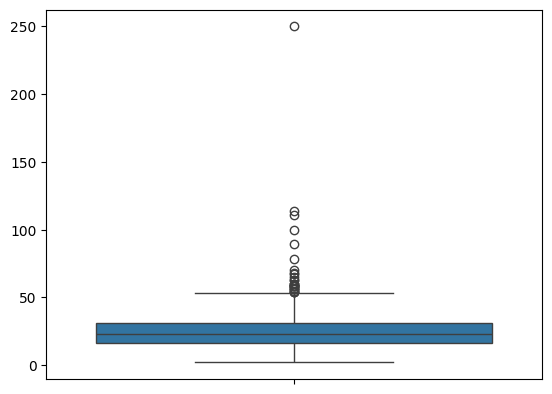

In [12]:
# check length of longest sentence 
lengths = [len(sentence) for sentence in encoded_train_sentences]
print(max(lengths))
sns.boxplot(lengths)
plt.show()

In [13]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100
train_padded = pad_sequences(encoded_train_sentences, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
train_tag_padded = pad_sequences(encoded_train_tags, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
val_padded = pad_sequences(encoded_val_sentences, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
val_tag_padded = pad_sequences(encoded_val_tags, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
test_padded = pad_sequences(encoded_test_sentences, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
test_tag_padded = pad_sequences(encoded_test_tags, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')

print(train_padded[0])
print(train_tag_padded[0])
print(len(train_padded[0]))
print(len(train_tag_padded[0]))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 3427 2309
    2 1744   65  343    2   41 1371    3  192   24    7 1120  270  708
 2310    4]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  2  2  7 11  5  6  7 20 12  4  1  3  4  6
  1  2 11  8]
100
100


In [14]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = ""
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [15]:
# Glove -> 50, 100, 200, 300
embedding_model = load_embedding_model(embedding_dimension=50)

In [16]:
def create_embedding_matrix(embedding_model, word2id, embedding_dim):
    vocab_size = len(word2id) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    OOV_embedding = np.random.rand(embedding_dim)
    count_not_in_glove = 0
    for word, i in tqdm(word2id.items()):
        try:
            embedding_matrix[i, :] = embedding_model[word]
        except KeyError:
            if word == '<UNK>':
                # give <UNK> a static embedding
                embedding_matrix[i, :] = OOV_embedding
                continue
            # If the word is not in the embedding model, it will have a random embedding vector, but check that its not already present
            embedding_vector = np.random.rand(embedding_dim)
            while embedding_vector in embedding_matrix:
                embedding_vector = np.random.rand(embedding_dim)
            embedding_matrix[i, :] = embedding_vector
            count_not_in_glove += 1
    print(f'Number of words that have no glove embedding: {count_not_in_glove}')
    return embedding_matrix

embedding_dim = 50
embedding_train_matrix = create_embedding_matrix(embedding_model, sentence_tokenizer.word_index, embedding_dim)
print(embedding_train_matrix.shape)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 49024.32it/s]

Number of words that have no glove embedding: 359
(7406, 50)


In [17]:
# For tags use one-hot encoding
from keras.utils import to_categorical

Y = to_categorical(train_tag_padded)
print(Y.shape)
print(Y[0])

(1959, 100, 46)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [18]:
print(train_tag_padded.shape)
print(train_padded.shape)

(1959, 100)
(1959, 100)


In [19]:
print("Embeddings shape: {}".format(embedding_train_matrix.shape))

Embeddings shape: (7406, 50)


In [20]:
# Split the data into train, val and test sets
X_train = train_padded
Y_train = Y
X_val = val_padded
Y_val = to_categorical(val_tag_padded)
X_test = test_padded
Y_test = to_categorical(test_tag_padded)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(1959, 100)
(1959, 100, 46)
(1277, 100)
(1277, 100, 46)
(638, 100)
(638, 100, 42)


In [21]:
def check_OOV_terms(X):
    count_OOV = 0
    for sentence in X:
        for word in sentence:
            if word == 1:
                count_OOV += 1
    print(f'Number of OOV terms: {count_OOV}')

check_OOV_terms(X_train)
check_OOV_terms(X_val)
check_OOV_terms(X_test)

Number of OOV terms: 0
Number of OOV terms: 3746
Number of OOV terms: 1969


In [22]:
# Baseline model: LSTM + FC

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, TimeDistributed, Dropout
from keras.optimizers import Adam

num_tags = Y_train.shape[2]

baseline = Sequential()
baseline.add(Embedding(input_dim=len(sentence_tokenizer.word_index) + 1, output_dim=50, input_length=MAX_SEQ_LENGTH, weights=[embedding_train_matrix], trainable=False))
baseline.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)))
baseline.add(TimeDistributed(Dense(num_tags, activation="softmax")))

In [23]:
baseline.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])

baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           370300    
                                                                 
 bidirectional (Bidirection  (None, 100, 256)          183296    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 100, 46)           11822     
 ributed)                                                        
                                                                 
Total params: 565418 (2.16 MB)
Trainable params: 195118 (762.18 KB)
Non-trainable params: 370300 (1.41 MB)
_________________________________________________________________


In [24]:
history_baseline = baseline.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=128, epochs=10, verbose=1)

Epoch 1/10
16/16 [==============================] - 18s 786ms/step - loss: 2.5347 - accuracy: 0.7329 - val_loss: 0.9648 - val_accuracy: 0.7784
Epoch 2/10
16/16 [==============================] - 12s 773ms/step - loss: 0.7889 - accuracy: 0.8034 - val_loss: 0.7179 - val_accuracy: 0.8014
Epoch 3/10
16/16 [==============================] - 14s 856ms/step - loss: 0.6621 - accuracy: 0.8210 - val_loss: 0.6460 - val_accuracy: 0.8232
Epoch 4/10
16/16 [==============================] - 13s 801ms/step - loss: 0.5955 - accuracy: 0.8416 - val_loss: 0.5872 - val_accuracy: 0.8463
Epoch 5/10
16/16 [==============================] - 12s 783ms/step - loss: 0.5347 - accuracy: 0.8628 - val_loss: 0.5313 - val_accuracy: 0.8637
Epoch 6/10
16/16 [==============================] - 13s 809ms/step - loss: 0.4768 - accuracy: 0.8780 - val_loss: 0.4812 - val_accuracy: 0.8767
Epoch 7/10
16/16 [==============================] - 13s 798ms/step - loss: 0.4285 - accuracy: 0.8897 - val_loss: 0.4373 - val_accuracy: 0.8870

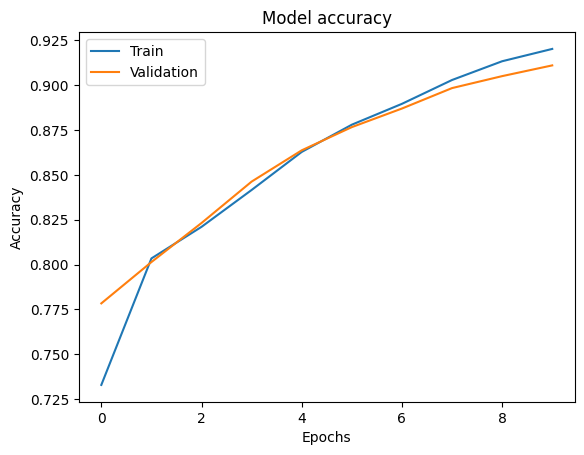

In [25]:
# plot results
plt.plot(history_baseline.history['accuracy'])
plt.plot(history_baseline.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
num_tags = Y_train.shape[2]

model1 = Sequential()
model1.add(Embedding(input_dim=len(sentence_tokenizer.word_index) + 1, output_dim=50, input_length=MAX_SEQ_LENGTH, weights=[embedding_train_matrix], trainable=False))
model1.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)))
model1.add(Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1)))
model1.add(TimeDistributed(Dense(num_tags, activation="softmax")))

In [27]:
model1.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])

In [28]:
history_model1 = model1.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=128, epochs=10, verbose=1)

Epoch 1/10
16/16 [==============================] - 37s 2s/step - loss: 2.1299 - accuracy: 0.7277 - val_loss: 0.8225 - val_accuracy: 0.7838
Epoch 2/10
16/16 [==============================] - 24s 2s/step - loss: 0.7536 - accuracy: 0.7897 - val_loss: 0.7383 - val_accuracy: 0.7917
Epoch 3/10
16/16 [==============================] - 25s 2s/step - loss: 0.7083 - accuracy: 0.8035 - val_loss: 0.7117 - val_accuracy: 0.8059
Epoch 4/10
16/16 [==============================] - 25s 2s/step - loss: 0.6798 - accuracy: 0.8101 - val_loss: 0.6845 - val_accuracy: 0.8087
Epoch 5/10
16/16 [==============================] - 25s 2s/step - loss: 0.6460 - accuracy: 0.8167 - val_loss: 0.6447 - val_accuracy: 0.8206
Epoch 6/10
16/16 [==============================] - 26s 2s/step - loss: 0.6014 - accuracy: 0.8314 - val_loss: 0.5955 - val_accuracy: 0.8434
Epoch 7/10
16/16 [==============================] - 26s 2s/step - loss: 0.5453 - accuracy: 0.8589 - val_loss: 0.5390 - val_accuracy: 0.8622
Epoch 8/10
16/16 [==

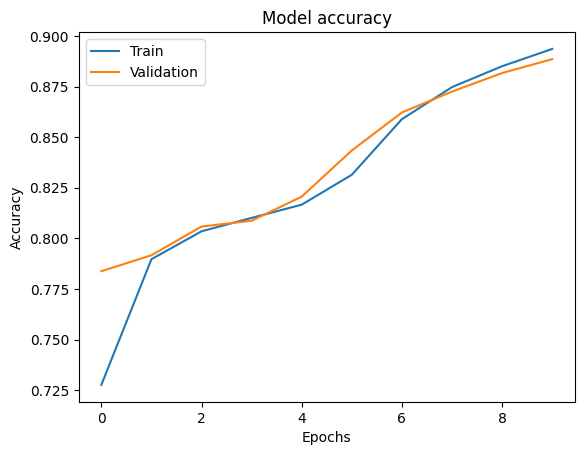

In [29]:
# plot results
plt.plot(history_model1.history['accuracy'])
plt.plot(history_model1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [30]:
num_tags = Y_train.shape[2]

model2 = Sequential()
model2.add(Embedding(input_dim=len(sentence_tokenizer.word_index) + 1 , output_dim=50, input_length=MAX_SEQ_LENGTH, weights=[embedding_train_matrix], trainable=False))
model2.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)))
model2.add(TimeDistributed(Dense(num_tags, activation="softmax")))
model2.add(TimeDistributed(Dense(num_tags, activation="softmax")))

In [31]:
model2.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])

In [32]:
history_model2 = model2.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=128, epochs=10, verbose=1)

Epoch 1/10
16/16 [==============================] - 21s 934ms/step - loss: 3.7843 - accuracy: 0.3262 - val_loss: 3.6532 - val_accuracy: 0.7558
Epoch 2/10
16/16 [==============================] - 14s 891ms/step - loss: 3.5921 - accuracy: 0.7592 - val_loss: 3.5474 - val_accuracy: 0.7558
Epoch 3/10
16/16 [==============================] - 14s 896ms/step - loss: 3.5204 - accuracy: 0.7592 - val_loss: 3.4893 - val_accuracy: 0.7558
Epoch 4/10
16/16 [==============================] - 14s 906ms/step - loss: 3.4633 - accuracy: 0.7592 - val_loss: 3.4345 - val_accuracy: 0.7558
Epoch 5/10
16/16 [==============================] - 14s 896ms/step - loss: 3.4074 - accuracy: 0.7623 - val_loss: 3.3785 - val_accuracy: 0.7606
Epoch 6/10
16/16 [==============================] - 14s 899ms/step - loss: 3.3500 - accuracy: 0.7709 - val_loss: 3.3218 - val_accuracy: 0.7692
Epoch 7/10
16/16 [==============================] - 14s 906ms/step - loss: 3.2934 - accuracy: 0.7810 - val_loss: 3.2664 - val_accuracy: 0.7739

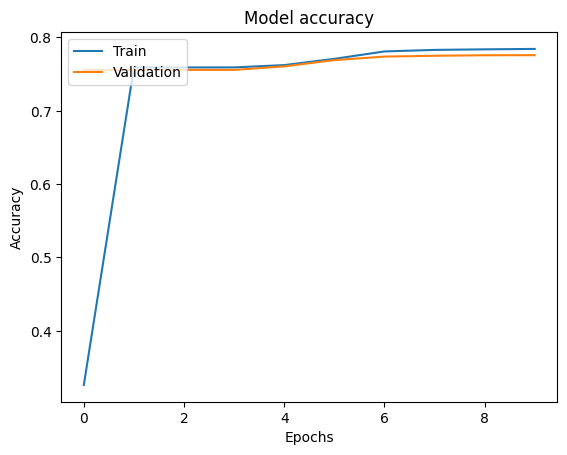

In [33]:
# plot results
plt.plot(history_model2.history['accuracy'])
plt.plot(history_model2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [34]:
#Metrics: Evaluate using macro-f1 score computer over all tokens
from sklearn.metrics import f1_score

def compute_f1(predictions, correct, idx2Label):
    label_pred = []
    for sentence in predictions:
        label_pred.append([idx2Label[element.argmax()] for element in sentence])
    label_correct = []
    for sentence in correct:
        label_correct.append([idx2Label[element.argmax()] for element in sentence])
    
    # flatten the list of lists
    flat_predictions = [item for sublist in label_pred for item in sublist]
    flat_correct = [item for sublist in label_correct for item in sublist]
    # compute f1 score
    f1 = f1_score(flat_correct, flat_predictions, average='macro')
    return f1

# Evaluate the model on the test set
predictions = model2.predict(X_test)
print(predictions.shape)
print(predictions[0])

ModuleNotFoundError: No module named 'sklearn'